# Exploratory Data Analysis: Texas Agriculture with Climate Data (2000-2023)

**Project:** Predicting Agricultural Statistics for Texas Counties Using Climate Data

**Authors:** Carter Dobbs, Johann Steinhoff, Jay Suh

**Date:** November 2025

---

## Overview
This notebook performs exploratory data analysis on a merged dataset combining:
- USDA NASS QuickStats agricultural data for Texas counties
- NOAA nClimDiv monthly climate data

The goal is to understand the dataset structure, identify patterns, and prepare for predictive modeling of agricultural outcomes based on climate conditions.

In [1]:
# Import necessary libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Python: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
NumPy: 2.3.1
Pandas: 2.3.2
Libraries imported successfully!


---
## 1. Load the Dataset

In [2]:
# Load the merged agriculture and climate dataset
data_path = "../data/texas_agriculture_with_climate_2000_2023.csv"
df = pd.read_csv(data_path, low_memory=False)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Total cells: {df.shape[0] * df.shape[1]:,}")

Dataset loaded successfully!
Shape: (398204, 120)
Total cells: 47,784,480


---
## 2. Dataset Size and Structure

### 2.1 Basic Information

In [3]:
# Display dataset dimensions
print("="*80)
print("DATASET DIMENSIONS")
print("="*80)
print(f"Number of instances (records): {df.shape[0]:,}")
print(f"Number of attributes (columns): {df.shape[1]:,}")
print(f"Total data points: {df.shape[0] * df.shape[1]:,}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print("="*80)

DATASET DIMENSIONS
Number of instances (records): 398,204
Number of attributes (columns): 120
Total data points: 47,784,480
Memory usage: 842.87 MB


In [4]:
# Display first few rows
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,SOURCE_DESC,SECTOR_DESC,GROUP_DESC,COMMODITY_DESC,CLASS_DESC,PRODN_PRACTICE_DESC,UTIL_PRACTICE_DESC,STATISTICCAT_DESC,UNIT_DESC,SHORT_DESC,DOMAIN_DESC,DOMAINCAT_DESC,AGG_LEVEL_DESC,STATE_ANSI,STATE_FIPS_CODE,STATE_ALPHA,STATE_NAME,ASD_CODE,ASD_DESC,COUNTY_ANSI,COUNTY_CODE,COUNTY_NAME,REGION_DESC,ZIP_5,WATERSHED_CODE,WATERSHED_DESC,CONGR_DISTRICT_CODE,COUNTRY_CODE,COUNTRY_NAME,LOCATION_DESC,YEAR,FREQ_DESC,BEGIN_CODE,END_CODE,REFERENCE_PERIOD_DESC,WEEK_ENDING,LOAD_TIME,VALUE,CV_%,COUNTY_FIPS,PRECIP_JAN,PRECIP_FEB,PRECIP_MAR,PRECIP_APR,PRECIP_MAY,PRECIP_JUN,PRECIP_JUL,PRECIP_AUG,PRECIP_SEP,PRECIP_OCT,PRECIP_NOV,PRECIP_DEC,TMAX_JAN,TMAX_FEB,TMAX_MAR,TMAX_APR,TMAX_MAY,TMAX_JUN,TMAX_JUL,TMAX_AUG,TMAX_SEP,TMAX_OCT,TMAX_NOV,TMAX_DEC,TMIN_JAN,TMIN_FEB,TMIN_MAR,TMIN_APR,TMIN_MAY,TMIN_JUN,TMIN_JUL,TMIN_AUG,TMIN_SEP,TMIN_OCT,TMIN_NOV,TMIN_DEC,TAVG_JAN,TAVG_FEB,TAVG_MAR,TAVG_APR,TAVG_MAY,TAVG_JUN,TAVG_JUL,TAVG_AUG,TAVG_SEP,TAVG_OCT,TAVG_NOV,TAVG_DEC,CDD_JAN,CDD_FEB,CDD_MAR,CDD_APR,CDD_MAY,CDD_JUN,CDD_JUL,CDD_AUG,CDD_SEP,CDD_OCT,CDD_NOV,CDD_DEC,HDD_JAN,HDD_FEB,HDD_MAR,HDD_APR,HDD_MAY,HDD_JUN,HDD_JUL,HDD_AUG,HDD_SEP,HDD_OCT,HDD_NOV,HDD_DEC,GROWING_SEASON_PRECIP,GROWING_SEASON_TEMP_AVG,GROWING_SEASON_TEMP_MAX,GROWING_SEASON_TEMP_MIN,ANNUAL_PRECIP,ANNUAL_TEMP_AVG,ANNUAL_CDD,ANNUAL_HDD
0,CENSUS,CROPS,VEGETABLES,SQUASH,WINTER,ALL PRODUCTION PRACTICES,FRESH MARKET,AREA HARVESTED,OPERATIONS,"SQUASH, WINTER, FRESH MARKET - OPERATIONS WITH...",TOTAL,NOT SPECIFIED,COUNTY,48.0,48,TX,TEXAS,40.0,BLACKLANDS,27.0,27,BELL,NaN,NaN,0.0,NaN,NaN,9000.0,UNITED STATES,"TEXAS, BLACKLANDS, BELL",2007,ANNUAL,0,0,YEAR,NaN,2012-01-01 00:00:00,1,NaN,48027,6.57,0.21,8.59,1.67,11.05,7.97,6.29,0.94,2.41,1.22,1.74,1.44,55.0,64.2,74.2,73.0,81.4,88.1,87.9,93.7,89.6,82.6,71.9,65.9,34.0,37.4,53.2,51.4,63.4,68.4,71.5,73.1,68.0,56.1,48.2,36.9,44.5,50.8,63.7,62.2,72.4,78.3,79.7,83.4,78.8,69.4,60.1,51.4,0.0,7.0,102.0,40.0,237.0,398.0,457.0,569.0,415.0,168.0,38.0,5.0,635.0,405.0,141.0,125.0,6.0,0.0,0.0,0.0,0.0,32.0,186.0,428.0,30.33,75.800000,85.616667,65.966667,50.10,66.225000,2436.0,1958.0
1,CENSUS,CROPS,FRUIT & TREE NUTS,PECANS,ALL CLASSES,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,AREA BEARING,OPERATIONS,PECANS - OPERATIONS WITH AREA BEARING,TOTAL,NOT SPECIFIED,COUNTY,48.0,48,TX,TEXAS,30.0,CROSS TIMBERS,417.0,417,SHACKELFORD,NaN,NaN,0.0,NaN,NaN,9000.0,UNITED STATES,"TEXAS, CROSS TIMBERS, SHACKELFORD",2012,ANNUAL,0,0,YEAR,NaN,2012-12-31 00:00:00,1,16.0,48417,3.18,1.39,1.52,0.56,2.07,2.19,1.14,1.70,6.10,0.53,0.09,0.19,62.8,61.4,73.1,84.0,88.7,94.6,98.3,97.8,89.1,75.6,72.9,62.4,34.6,38.3,51.4,56.9,64.9,68.9,73.0,71.1,65.0,51.5,44.6,35.4,48.7,49.8,62.3,70.4,76.8,81.8,85.7,84.4,77.1,63.6,58.8,48.8,8.0,6.0,92.0,189.0,366.0,502.0,640.0,602.0,367.0,74.0,29.0,0.0,514.0,431.0,177.0,26.0,0.0,0.0,0.0,0.0,0.0,118.0,216.0,501.0,13.76,79.366667,92.083333,66.633333,20.66,67.350000,2875.0,1983.0
2,CENSUS,CROPS,FRUIT & TREE NUTS,TANGERINES,ALL CLASSES,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,AREA BEARING & NON-BEARING,ACRES,TANGERINES - ACRES BEARING & NON-BEARING,TOTAL,NOT SPECIFIED,COUNTY,48.0,48,TX,TEXAS,70.0,EDWARDS PLATEAU,265.0,265,KERR,NaN,NaN,0.0,NaN,NaN,9000.0,UNITED STATES,"TEXAS, EDWARDS PLATEAU, KERR",2007,ANNUAL,0,0,YEAR,NaN,2012-01-01 00:00:00,(D),NaN,48265,3.12,0.08,6.95,2.03,7.81,5.55,7.39,6.17,3.07,0.82,0.83,0.40,53.2,64.1,72.2,73.6,79.8,86.1,85.4,89.3,86.1,82.0,70.0,64.7,33.4,36.5,51.6,49.4,61.8,67.6,68.9,70.0,65.5,53.6,46.6,35.2,43.3,50.3,61.9,61.5,70.8,76.9,77.1,79.6,75.8,67.8,58.3,49.9,0.0,0.0,66.0,34.0,193.0,356.0,376.0,454.0,324.0,136.0,20.0,0.0,673.0,416.0,163.0,139.0,12.0,0.0,0.0,0.0,0.0,50.0,223.0,467.0,32.02,73.616667,83.383333,63.866667,44.22,64.433333,1959.0,2143.0
3,CENSUS,CROPS,FRUIT & TREE NUTS,PECANS,ALL CLASSES,ALL PRODUCTION PRACTICES,ALL UTILIZATION PRACTICES,AREA BEARING,ACRES,PECANS - ACRES BEARING,TOTAL,NOT SPECIFIED,COUNTY,48.0,48,TX,TEXAS,30.0,CROSS TIMBERS,337.0,337,MONTAGUE,NaN,NaN,0.0,NaN,NaN,9000.0,UNITED STATES,"TEXAS, CROSS TIMBE

In [5]:
# Display data types and non-null counts
print("\nColumn Information:")
df.info()


Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398204 entries, 0 to 398203
Columns: 120 entries, SOURCE_DESC to ANNUAL_HDD
dtypes: float64(90), int64(6), object(24)
memory usage: 364.6+ MB


### 2.2 Column Names

In [6]:
# Display all column names
print("\nAll Columns in Dataset:")
print("="*80)
for i, col in enumerate(df.columns, 1):
    print(f"{i:3d}. {col}")
print("="*80)


All Columns in Dataset:
  1. SOURCE_DESC
  2. SECTOR_DESC
  3. GROUP_DESC
  4. COMMODITY_DESC
  5. CLASS_DESC
  6. PRODN_PRACTICE_DESC
  7. UTIL_PRACTICE_DESC
  8. STATISTICCAT_DESC
  9. UNIT_DESC
 10. SHORT_DESC
 11. DOMAIN_DESC
 12. DOMAINCAT_DESC
 13. AGG_LEVEL_DESC
 14. STATE_ANSI
 15. STATE_FIPS_CODE
 16. STATE_ALPHA
 17. STATE_NAME
 18. ASD_CODE
 19. ASD_DESC
 20. COUNTY_ANSI
 21. COUNTY_CODE
 22. COUNTY_NAME
 23. REGION_DESC
 24. ZIP_5
 25. WATERSHED_CODE
 26. WATERSHED_DESC
 27. CONGR_DISTRICT_CODE
 28. COUNTRY_CODE
 29. COUNTRY_NAME
 30. LOCATION_DESC
 31. YEAR
 32. FREQ_DESC
 33. BEGIN_CODE
 34. END_CODE
 35. REFERENCE_PERIOD_DESC
 36. WEEK_ENDING
 37. LOAD_TIME
 38. VALUE
 39. CV_%
 40. COUNTY_FIPS
 41. PRECIP_JAN
 42. PRECIP_FEB
 43. PRECIP_MAR
 44. PRECIP_APR
 45. PRECIP_MAY
 46. PRECIP_JUN
 47. PRECIP_JUL
 48. PRECIP_AUG
 49. PRECIP_SEP
 50. PRECIP_OCT
 51. PRECIP_NOV
 52. PRECIP_DEC
 53. TMAX_JAN
 54. TMAX_FEB
 55. TMAX_MAR
 56. TMAX_APR
 57. TMAX_MAY
 58. TMAX_JUN
 59.

---
## 3. Attribute Categories and Descriptions

The dataset contains attributes from three main sources:
1. **USDA Agricultural Data** - Crop information and statistics
2. **NOAA Climate Data** - Monthly temperature and precipitation
3. **Engineered Features** - Derived seasonal and annual aggregates

In [7]:
# Categorize columns
usda_columns = [
    'SOURCE_DESC', 'SECTOR_DESC', 'GROUP_DESC', 'COMMODITY_DESC', 'CLASS_DESC',
    'PRODN_PRACTICE_DESC', 'UTIL_PRACTICE_DESC', 'STATISTICCAT_DESC', 'UNIT_DESC',
    'SHORT_DESC', 'DOMAIN_DESC', 'DOMAINCAT_DESC', 'AGG_LEVEL_DESC'
]

location_columns = [
    'STATE_ANSI', 'STATE_FIPS_CODE', 'STATE_ALPHA', 'STATE_NAME',
    'ASD_CODE', 'ASD_DESC', 'COUNTY_ANSI', 'COUNTY_CODE', 'COUNTY_NAME',
    'REGION_DESC', 'ZIP_5', 'WATERSHED_CODE', 'WATERSHED_DESC',
    'CONGR_DISTRICT_CODE', 'COUNTRY_CODE', 'COUNTRY_NAME', 'LOCATION_DESC',
    'COUNTY_FIPS'
]

temporal_columns = [
    'YEAR', 'FREQ_DESC', 'BEGIN_CODE', 'END_CODE', 'REFERENCE_PERIOD_DESC',
    'WEEK_ENDING', 'LOAD_TIME'
]

target_columns = ['VALUE', 'CV_%']

# Climate columns
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
precip_columns = [f'PRECIP_{month}' for month in months]
tmax_columns = [f'TMAX_{month}' for month in months]
tmin_columns = [f'TMIN_{month}' for month in months]
tavg_columns = [f'TAVG_{month}' for month in months]
cdd_columns = [f'CDD_{month}' for month in months]
hdd_columns = [f'HDD_{month}' for month in months]

engineered_columns = [
    'GROWING_SEASON_PRECIP', 'GROWING_SEASON_TEMP_AVG',
    'GROWING_SEASON_TEMP_MAX', 'GROWING_SEASON_TEMP_MIN',
    'ANNUAL_PRECIP', 'ANNUAL_TEMP_AVG', 'ANNUAL_CDD', 'ANNUAL_HDD'
]

print("\nAttribute Categories:")
print("="*80)
print(f"USDA Agricultural Attributes: {len(usda_columns)}")
print(f"Location/Geographic Attributes: {len(location_columns)}")
print(f"Temporal Attributes: {len(temporal_columns)}")
print(f"Target Variables: {len(target_columns)}")
print(f"Monthly Precipitation: {len(precip_columns)}")
print(f"Monthly Max Temperature: {len(tmax_columns)}")
print(f"Monthly Min Temperature: {len(tmin_columns)}")
print(f"Monthly Avg Temperature: {len(tavg_columns)}")
print(f"Monthly Cooling Degree Days: {len(cdd_columns)}")
print(f"Monthly Heating Degree Days: {len(hdd_columns)}")
print(f"Engineered Climate Features: {len(engineered_columns)}")
print("="*80)
print(f"Total: {len(df.columns)} columns")


Attribute Categories:
USDA Agricultural Attributes: 13
Location/Geographic Attributes: 18
Temporal Attributes: 7
Target Variables: 2
Monthly Precipitation: 12
Monthly Max Temperature: 12
Monthly Min Temperature: 12
Monthly Avg Temperature: 12
Monthly Cooling Degree Days: 12
Monthly Heating Degree Days: 12
Engineered Climate Features: 8
Total: 120 columns


---
## 4. Detailed Attribute Descriptions

### 4.1 USDA Agricultural Attributes

In [8]:
# Describe USDA agricultural columns
attribute_descriptions = {
    'SOURCE_DESC': 'Data source (e.g., CENSUS, SURVEY)',
    'SECTOR_DESC': 'Agricultural sector (e.g., CROPS, ANIMALS & PRODUCTS)',
    'GROUP_DESC': 'Commodity group (e.g., FIELD CROPS, VEGETABLES, FRUIT & TREE NUTS)',
    'COMMODITY_DESC': 'Specific commodity/crop (e.g., CORN, WHEAT, COTTON)',
    'CLASS_DESC': 'Commodity class/variety',
    'PRODN_PRACTICE_DESC': 'Production practice (e.g., IRRIGATED, NON-IRRIGATED)',
    'UTIL_PRACTICE_DESC': 'Utilization practice (e.g., GRAIN, SILAGE)',
    'STATISTICCAT_DESC': 'Type of statistic (e.g., YIELD, PRODUCTION, AREA HARVESTED)',
    'UNIT_DESC': 'Unit of measurement (e.g., BU/ACRE, TONS, $)',
    'SHORT_DESC': 'Complete description of the statistic',
    'DOMAIN_DESC': 'Domain category',
    'DOMAINCAT_DESC': 'Domain category description',
    'AGG_LEVEL_DESC': 'Geographic aggregation level'
}

print("\nUSDA Agricultural Attribute Descriptions:")
print("="*80)
for col in usda_columns:
    if col in df.columns:
        unique_count = df[col].nunique()
        print(f"\n{col}:")
        print(f"  Description: {attribute_descriptions.get(col, 'N/A')}")
        print(f"  Type: {df[col].dtype}")
        print(f"  Unique values: {unique_count}")
        if unique_count <= 10:
            print(f"  Values: {df[col].unique()[:10].tolist()}")
print("="*80)


USDA Agricultural Attribute Descriptions:

SOURCE_DESC:
  Description: Data source (e.g., CENSUS, SURVEY)
  Type: object
  Unique values: 2
  Values: ['CENSUS', 'SURVEY']

SECTOR_DESC:
  Description: Agricultural sector (e.g., CROPS, ANIMALS & PRODUCTS)
  Type: object
  Unique values: 1
  Values: ['CROPS']

GROUP_DESC:
  Description: Commodity group (e.g., FIELD CROPS, VEGETABLES, FRUIT & TREE NUTS)
  Type: object
  Unique values: 5
  Values: ['VEGETABLES', 'FRUIT & TREE NUTS', 'FIELD CROPS', 'CROP TOTALS', 'HORTICULTURE']

COMMODITY_DESC:
  Description: Specific commodity/crop (e.g., CORN, WHEAT, COTTON)
  Type: object
  Unique values: 165

CLASS_DESC:
  Description: Commodity class/variety
  Type: object
  Unique values: 85

PRODN_PRACTICE_DESC:
  Description: Production practice (e.g., IRRIGATED, NON-IRRIGATED)
  Type: object
  Unique values: 8
  Values: ['ALL PRODUCTION PRACTICES', 'IRRIGATED', 'NON-IRRIGATED', 'IN THE OPEN', 'UNDER PROTECTION', 'IN THE OPEN, IRRIGATED', 'PRODUCTI

### 4.2 Location and Geographic Attributes

In [9]:
# Analyze location columns
print("\nLocation/Geographic Attributes:")
print("="*80)
location_desc = {
    'STATE_NAME': 'State name',
    'COUNTY_NAME': 'County name',
    'COUNTY_FIPS': 'Federal Information Processing Standard county code',
    'ASD_DESC': 'Agricultural Statistics District',
    'REGION_DESC': 'Geographic region'
}

for col in ['STATE_NAME', 'COUNTY_NAME', 'COUNTY_FIPS', 'ASD_DESC']:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Description: {location_desc.get(col, 'Geographic identifier')}")
        print(f"  Unique values: {df[col].nunique()}")
        if col == 'COUNTY_NAME':
            print(f"  Sample counties: {df[col].unique()[:10].tolist()}")
print("="*80)


Location/Geographic Attributes:

STATE_NAME:
  Description: State name
  Unique values: 1

COUNTY_NAME:
  Description: County name
  Unique values: 256
  Sample counties: ['BELL', 'SHACKELFORD', 'KERR', 'MONTAGUE', 'DAWSON', 'OTHER (COMBINED) COUNTIES', 'HALE', 'TERRY', 'WOOD', 'LIMESTONE']

COUNTY_FIPS:
  Description: Federal Information Processing Standard county code
  Unique values: 255

ASD_DESC:
  Description: Agricultural Statistics District
  Unique values: 15


### 4.3 Temporal Attributes

In [10]:
# Analyze temporal attributes
print("\nTemporal Attributes:")
print("="*80)
if 'YEAR' in df.columns:
    print(f"\nYEAR:")
    print(f"  Description: Year of observation")
    print(f"  Range: {df['YEAR'].min()} to {df['YEAR'].max()}")
    print(f"  Unique years: {df['YEAR'].nunique()}")
    print(f"  Years covered: {sorted(df['YEAR'].unique())}")
print("="*80)


Temporal Attributes:

YEAR:
  Description: Year of observation
  Range: 2000 to 2023
  Unique years: 24
  Years covered: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


### 4.4 Target Variable

In [11]:
# Analyze target variable
print("\nTarget Variable:")
print("="*80)
if 'VALUE' in df.columns:
    # Convert VALUE to numeric, handling non-numeric values
    df['VALUE_numeric'] = pd.to_numeric(df['VALUE'], errors='coerce')
    
    print(f"\nVALUE:")
    print(f"  Description: Agricultural statistic value (varies by STATISTICCAT_DESC and UNIT_DESC)")
    print(f"  Type: {df['VALUE'].dtype}")
    print(f"  Non-null count: {df['VALUE'].notna().sum():,}")
    print(f"  Null count: {df['VALUE'].isna().sum():,}")
    print(f"  Numeric values: {df['VALUE_numeric'].notna().sum():,}")
    print(f"\n  Numeric VALUE Statistics:")
    print(f"    Min: {df['VALUE_numeric'].min()}")
    print(f"    Max: {df['VALUE_numeric'].max()}")
    print(f"    Mean: {df['VALUE_numeric'].mean():.2f}")
    print(f"    Median: {df['VALUE_numeric'].median():.2f}")
    print(f"    Std Dev: {df['VALUE_numeric'].std():.2f}")
    
    # Check for non-numeric values
    non_numeric = df[df['VALUE_numeric'].isna() & df['VALUE'].notna()]['VALUE'].unique()
    if len(non_numeric) > 0:
        print(f"\n  Non-numeric values found: {non_numeric[:10]}")
print("="*80)


Target Variable:

VALUE:
  Description: Agricultural statistic value (varies by STATISTICCAT_DESC and UNIT_DESC)
  Type: object
  Non-null count: 398,204
  Null count: 0
  Numeric values: 210,970

  Numeric VALUE Statistics:
    Min: 0.0
    Max: 999.0
    Mean: 68.16
    Median: 6.00
    Std Dev: 168.92

  Non-numeric values found: ['(D)' '1,919' '102,851,000' '1,500' '5,500' '1,448,000' '40,192' '3,000'
 '22,000' '4,378']


### 4.5 Climate Attributes - Monthly Precipitation

In [12]:
# Analyze monthly precipitation
print("\nMonthly Precipitation Attributes (inches):")
print("="*80)
precip_stats = pd.DataFrame()
for col in precip_columns:
    if col in df.columns:
        precip_stats[col] = [
            df[col].min(),
            df[col].max(),
            df[col].mean(),
            df[col].std()
        ]

precip_stats.index = ['Min', 'Max', 'Mean', 'Std Dev']
print(precip_stats.T.round(2))
print("="*80)


Monthly Precipitation Attributes (inches):
            Min    Max  Mean  Std Dev
PRECIP_JAN  0.0   9.79  2.33     2.12
PRECIP_FEB  0.0  11.45  1.65     1.47
PRECIP_MAR  0.0  11.74  2.99     2.35
PRECIP_APR  0.0  11.88  2.22     1.67
PRECIP_MAY  0.0  23.41  3.52     2.36
PRECIP_JUN  0.0  16.20  3.32     2.48
PRECIP_JUL  0.0  16.30  3.27     2.95
PRECIP_AUG  0.0  46.04  3.91     4.71
PRECIP_SEP  0.0  19.74  2.72     1.99
PRECIP_OCT  0.0  23.18  2.63     2.51
PRECIP_NOV  0.0  17.76  1.88     2.04
PRECIP_DEC  0.0  11.91  2.09     1.98


### 4.6 Climate Attributes - Monthly Temperatures

In [13]:
# Analyze temperature ranges
print("\nMonthly Temperature Attributes (Fahrenheit):")
print("="*80)

# Sample a few months for detailed display
sample_months = ['JAN', 'APR', 'JUL', 'OCT']
temp_summary = []

for month in sample_months:
    tmax_col = f'TMAX_{month}'
    tmin_col = f'TMIN_{month}'
    tavg_col = f'TAVG_{month}'
    
    if all(col in df.columns for col in [tmax_col, tmin_col, tavg_col]):
        temp_summary.append({
            'Month': month,
            'TMAX_Min': df[tmax_col].min(),
            'TMAX_Max': df[tmax_col].max(),
            'TMAX_Mean': df[tmax_col].mean(),
            'TMIN_Min': df[tmin_col].min(),
            'TMIN_Max': df[tmin_col].max(),
            'TMIN_Mean': df[tmin_col].mean(),
            'TAVG_Mean': df[tavg_col].mean()
        })

temp_df = pd.DataFrame(temp_summary)
print(temp_df.round(1))
print("\n(Showing sample months: January, April, July, October)")
print("="*80)


Monthly Temperature Attributes (Fahrenheit):
  Month  TMAX_Min  TMAX_Max  TMAX_Mean  TMIN_Min  TMIN_Max  TMIN_Mean  \
0   JAN      38.2      78.8       59.8      17.1      56.8       35.5   
1   APR      63.4      95.2       78.9      32.3      70.2       54.3   
2   JUL      84.8     106.3       94.3      60.8      80.3       72.0   
3   OCT      62.3      92.8       79.0      34.5      71.3       54.2   

   TAVG_Mean  
0       47.6  
1       66.6  
2       83.1  
3       66.6  

(Showing sample months: January, April, July, October)


### 4.7 Climate Attributes - Degree Days

In [14]:
# Analyze degree days
print("\nDegree Days Attributes:")
print("="*80)
print("\nCooling Degree Days (CDD) - Energy needed for cooling:")
cdd_stats = pd.DataFrame()
for col in ['CDD_JAN', 'CDD_APR', 'CDD_JUL', 'CDD_OCT']:
    if col in df.columns:
        cdd_stats[col] = [df[col].min(), df[col].max(), df[col].mean()]
cdd_stats.index = ['Min', 'Max', 'Mean']
print(cdd_stats.T.round(1))

print("\nHeating Degree Days (HDD) - Energy needed for heating:")
hdd_stats = pd.DataFrame()
for col in ['HDD_JAN', 'HDD_APR', 'HDD_JUL', 'HDD_OCT']:
    if col in df.columns:
        hdd_stats[col] = [df[col].min(), df[col].max(), df[col].mean()]
hdd_stats.index = ['Min', 'Max', 'Mean']
print(hdd_stats.T.round(1))
print("="*80)


Degree Days Attributes:

Cooling Degree Days (CDD) - Energy needed for cooling:
           Min    Max   Mean
CDD_JAN    0.0  174.0   13.2
CDD_APR    0.0  491.0  127.8
CDD_JUL  269.0  864.0  561.6
CDD_OCT    0.0  492.0  128.2

Heating Degree Days (HDD) - Energy needed for heating:
          Min     Max   Mean
HDD_JAN  99.0  1148.0  551.6
HDD_APR   0.0   476.0   79.7
HDD_JUL   0.0     0.0    0.0
HDD_OCT   0.0   477.0   78.1


### 4.8 Engineered Climate Features

In [15]:
# Analyze engineered features
print("\nEngineered Climate Features:")
print("="*80)
eng_desc = {
    'GROWING_SEASON_PRECIP': 'Total precipitation April-September (inches)',
    'GROWING_SEASON_TEMP_AVG': 'Average temperature April-September (°F)',
    'GROWING_SEASON_TEMP_MAX': 'Average max temperature April-September (°F)',
    'GROWING_SEASON_TEMP_MIN': 'Average min temperature April-September (°F)',
    'ANNUAL_PRECIP': 'Total annual precipitation (inches)',
    'ANNUAL_TEMP_AVG': 'Annual average temperature (°F)',
    'ANNUAL_CDD': 'Total annual cooling degree days',
    'ANNUAL_HDD': 'Total annual heating degree days'
}

for col in engineered_columns:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Description: {eng_desc.get(col, 'N/A')}")
        print(f"  Range: {df[col].min():.2f} to {df[col].max():.2f}")
        print(f"  Mean: {df[col].mean():.2f}")
        print(f"  Std Dev: {df[col].std():.2f}")
print("="*80)


Engineered Climate Features:

GROWING_SEASON_PRECIP:
  Description: Total precipitation April-September (inches)
  Range: 1.53 to 71.66
  Mean: 18.95
  Std Dev: 8.94

GROWING_SEASON_TEMP_AVG:
  Description: Average temperature April-September (°F)
  Range: 67.15 to 85.70
  Mean: 77.32
  Std Dev: 3.31

GROWING_SEASON_TEMP_MAX:
  Description: Average max temperature April-September (°F)
  Range: 81.30 to 98.68
  Mean: 88.92
  Std Dev: 3.11

GROWING_SEASON_TEMP_MIN:
  Description: Average min temperature April-September (°F)
  Range: 52.68 to 76.05
  Mean: 65.70
  Std Dev: 4.26

ANNUAL_PRECIP:
  Description: Total annual precipitation (inches)
  Range: 2.97 to 95.03
  Mean: 32.51
  Std Dev: 14.55

ANNUAL_TEMP_AVG:
  Description: Annual average temperature (°F)
  Range: 54.83 to 77.10
  Mean: 66.21
  Std Dev: 4.20

ANNUAL_CDD:
  Description: Total annual cooling degree days
  Range: 923.00 to 4909.00
  Mean: 2630.56
  Std Dev: 679.48

ANNUAL_HDD:
  Description: Total annual heating degree

---
## 5. Missing Values Analysis

In [16]:
# Check for missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

print("\nMissing Values Summary:")
print("="*80)
if len(missing_data) > 0:
    print(f"\nColumns with missing values: {len(missing_data)}")
    print(missing_data.to_string(index=False))
else:
    print("No missing values found!")
print("="*80)


Missing Values Summary:

Columns with missing values: 89
                 Column  Missing_Count  Missing_Percentage
            REGION_DESC         398204          100.000000
            WEEK_ENDING         398204          100.000000
                  ZIP_5         398204          100.000000
         WATERSHED_DESC         398204          100.000000
    CONGR_DISTRICT_CODE         398204          100.000000
                   CV_%         211970           53.231509
          VALUE_numeric         187234           47.019618
             PRECIP_JAN          14133            3.549186
            COUNTY_ANSI          14133            3.549186
             PRECIP_OCT          14133            3.549186
             PRECIP_MAR          14133            3.549186
             PRECIP_APR          14133            3.549186
             PRECIP_MAY          14133            3.549186
             PRECIP_JUN          14133            3.549186
             PRECIP_JUL          14133            3.54918

---
## 6. Key Categorical Variables

In [17]:
# Analyze key categorical variables
print("\nKey Categorical Variables:")
print("="*80)

# Counties
if 'COUNTY_NAME' in df.columns:
    print(f"\nUnique Counties: {df['COUNTY_NAME'].nunique()}")
    print(f"Top 10 counties by record count:")
    print(df['COUNTY_NAME'].value_counts().head(10))

# Crops
if 'COMMODITY_DESC' in df.columns:
    print(f"\n\nUnique Commodities/Crops: {df['COMMODITY_DESC'].nunique()}")
    print(f"Top 10 commodities by record count:")
    print(df['COMMODITY_DESC'].value_counts().head(10))

# Statistics Types
if 'STATISTICCAT_DESC' in df.columns:
    print(f"\n\nUnique Statistic Types: {df['STATISTICCAT_DESC'].nunique()}")
    print(f"Statistic types:")
    print(df['STATISTICCAT_DESC'].value_counts())

print("="*80)


Key Categorical Variables:

Unique Counties: 256
Top 10 counties by record count:
COUNTY_NAME
OTHER (COMBINED) COUNTIES    13872
HIDALGO                       3424
LUBBOCK                       3012
MEDINA                        2961
BRAZORIA                      2937
CAMERON                       2892
WHARTON                       2824
WILLIAMSON                    2783
HUNT                          2776
COLLIN                        2763
Name: count, dtype: int64


Unique Commodities/Crops: 165
Top 10 commodities by record count:
COMMODITY_DESC
COTTON              47859
WHEAT               45658
SORGHUM             27754
HAY                 22679
CORN                21495
PECANS              14528
VEGETABLE TOTALS    14198
HAY & HAYLAGE       12663
HAYLAGE             11293
OATS                 8002
Name: count, dtype: int64


Unique Statistic Types: 16
Statistic types:
STATISTICCAT_DESC
AREA HARVESTED                166318
PRODUCTION                     45786
SALES                 

---
## 7. Data Summary Statistics

In [18]:
# Comprehensive numerical summary
print("\nNumerical Attributes Summary:")
print("="*80)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Total numerical columns: {len(numeric_cols)}")
df[numeric_cols].describe().T


Numerical Attributes Summary:
Total numerical columns: 97


,count,mean,std,min,25%,50%,75%,max
STATE_ANSI,398204.0,48.000000,0.000000,48.000000,48.000000,48.000000,48.000000,48.000000
STATE_FIPS_CODE,398204.0,48.000000,0.000000,48.000000,48.000000,48.000000,48.000000,48.000000
ASD_CODE,398204.0,49.134444,27.868408,11.000000,22.000000,51.000000,81.000000,99.000000
COUNTY_ANSI,384071.0,246.935694,147.434581,1.000000,121.000000,233.000000,371.000000,507.000000
COUNTY_CODE,398204.0,273.592362,200.688343,1.000000,125.000000,245.000000,387.000000,998.000000
REGION_DESC,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP_5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WATERSHED_CODE,398204.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
WATERSHED_DESC,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONGR_DISTRICT_CODE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
## 8. Dataset Summary Report

### Complete Dataset Overview

In [19]:
# Generate comprehensive summary report
print("\n" + "="*80)
print("COMPREHENSIVE DATASET SUMMARY REPORT")
print("="*80)
print(f"\n1. DATASET SIZE")
print(f"   - Total instances: {df.shape[0]:,}")
print(f"   - Total attributes: {df.shape[1]:,}")
print(f"   - Total data points: {df.shape[0] * df.shape[1]:,}")
print(f"   - Memory usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

print(f"\n2. ATTRIBUTE BREAKDOWN")
print(f"   - USDA Agricultural: {len([c for c in usda_columns if c in df.columns])}")
print(f"   - Location/Geographic: {len([c for c in location_columns if c in df.columns])}")
print(f"   - Temporal: {len([c for c in temporal_columns if c in df.columns])}")
print(f"   - Climate (Monthly): {len([c for c in precip_columns + tmax_columns + tmin_columns + tavg_columns + cdd_columns + hdd_columns if c in df.columns])}")
print(f"   - Engineered Features: {len([c for c in engineered_columns if c in df.columns])}")
print(f"   - Target Variables: {len([c for c in target_columns if c in df.columns])}")

if 'YEAR' in df.columns:
    print(f"\n3. TEMPORAL COVERAGE")
    print(f"   - Years: {df['YEAR'].min()} to {df['YEAR'].max()}")
    print(f"   - Total years: {df['YEAR'].nunique()}")

if 'COUNTY_NAME' in df.columns:
    print(f"\n4. GEOGRAPHIC COVERAGE")
    print(f"   - Unique counties: {df['COUNTY_NAME'].nunique()}")

if 'COMMODITY_DESC' in df.columns:
    print(f"\n5. AGRICULTURAL COVERAGE")
    print(f"   - Unique commodities/crops: {df['COMMODITY_DESC'].nunique()}")
    
if 'STATISTICCAT_DESC' in df.columns:
    print(f"   - Statistic types: {df['STATISTICCAT_DESC'].nunique()}")

print(f"\n6. DATA QUALITY")
total_missing = df.isnull().sum().sum()
total_cells = df.shape[0] * df.shape[1]
print(f"   - Total missing values: {total_missing:,}")
print(f"   - Missing percentage: {(total_missing/total_cells)*100:.2f}%")
print(f"   - Columns with missing values: {len(missing_data)}")

print("\n" + "="*80)
print("END OF SUMMARY REPORT")
print("="*80)


COMPREHENSIVE DATASET SUMMARY REPORT

1. DATASET SIZE
   - Total instances: 398,204
   - Total attributes: 121
   - Total data points: 48,182,684
   - Memory usage: 845.91 MB

2. ATTRIBUTE BREAKDOWN
   - USDA Agricultural: 13
   - Location/Geographic: 18
   - Temporal: 7
   - Climate (Monthly): 72
   - Engineered Features: 8
   - Target Variables: 2

3. TEMPORAL COVERAGE
   - Years: 2000 to 2023
   - Total years: 24

4. GEOGRAPHIC COVERAGE
   - Unique counties: 256

5. AGRICULTURAL COVERAGE
   - Unique commodities/crops: 165
   - Statistic types: 16

6. DATA QUALITY
   - Total missing values: 3,535,258
   - Missing percentage: 7.34%
   - Columns with missing values: 89

END OF SUMMARY REPORT


---
## 9. Data Visualization (Optional)

### 9.1 Distribution of Records by Year

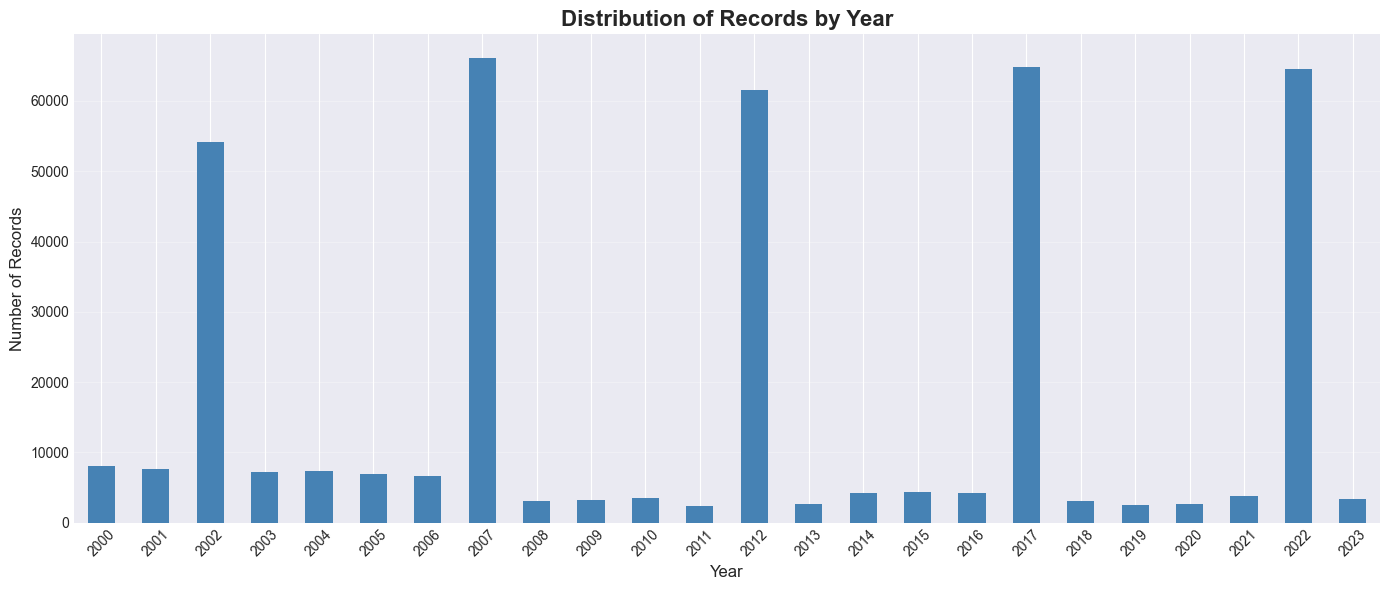

In [20]:
# Plot records by year
if 'YEAR' in df.columns:
    plt.figure(figsize=(14, 6))
    df['YEAR'].value_counts().sort_index().plot(kind='bar', color='steelblue')
    plt.title('Distribution of Records by Year', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Records', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

### 9.2 Top Commodities

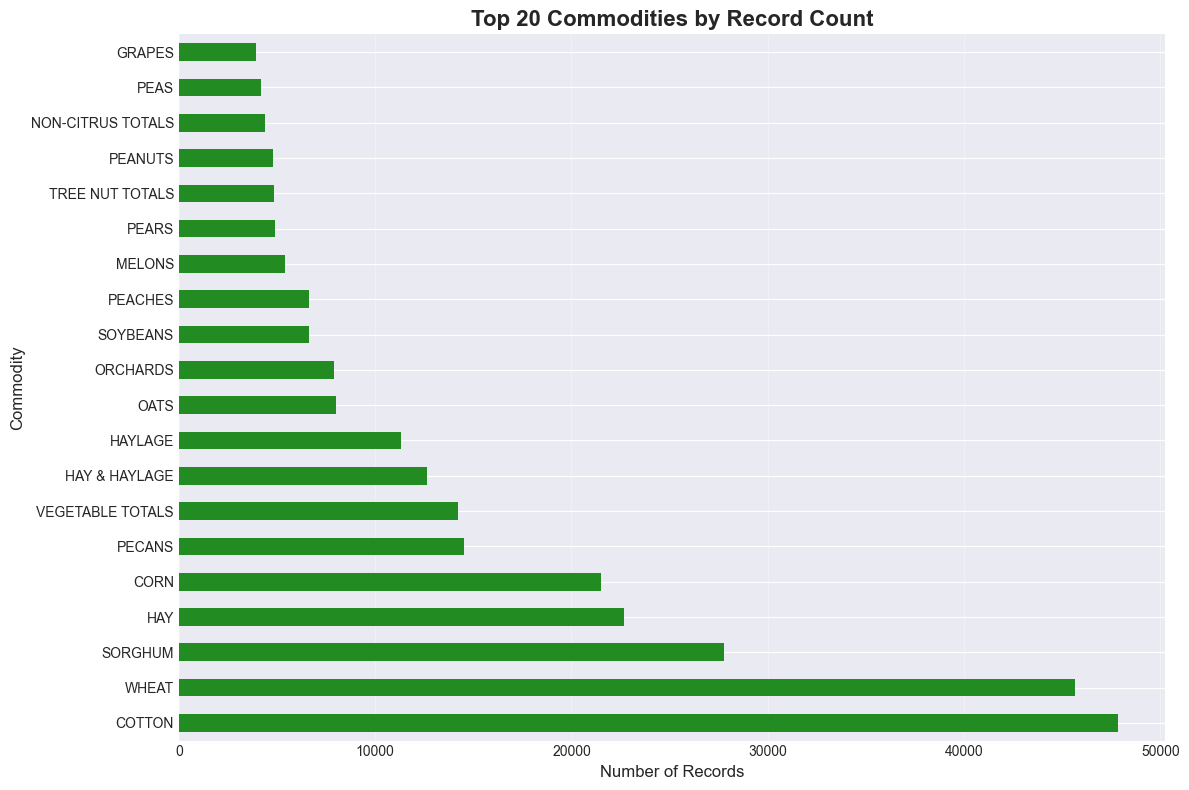

In [21]:
# Plot top commodities
if 'COMMODITY_DESC' in df.columns:
    plt.figure(figsize=(12, 8))
    df['COMMODITY_DESC'].value_counts().head(20).plot(kind='barh', color='forestgreen')
    plt.title('Top 20 Commodities by Record Count', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Records', fontsize=12)
    plt.ylabel('Commodity', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

### 9.3 Climate Feature Correlation Heatmap

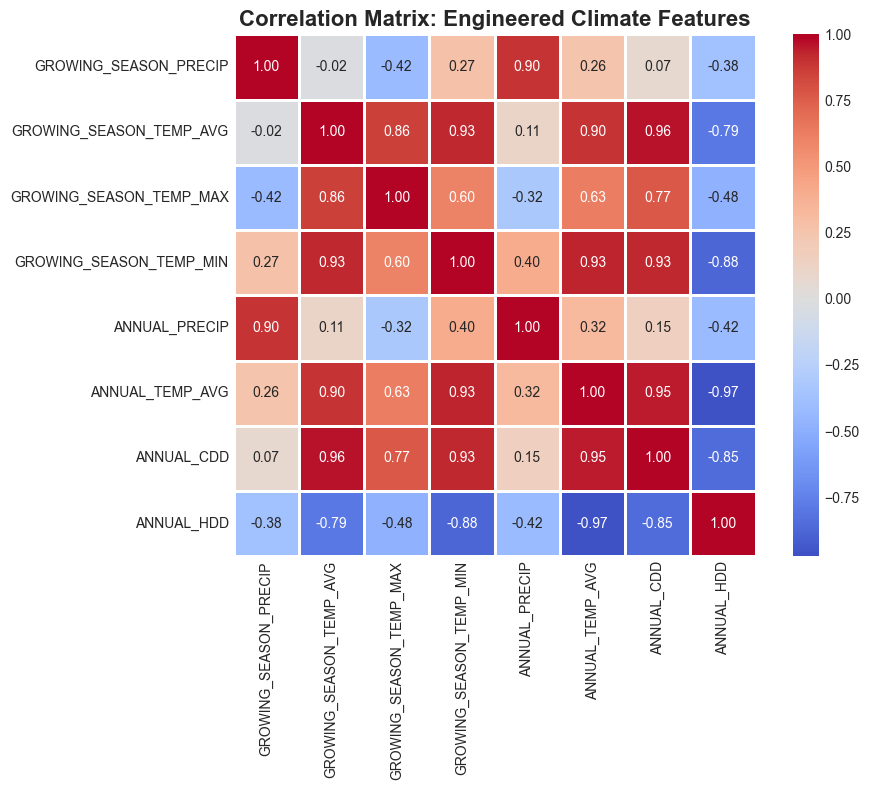

In [22]:
# Plot correlation heatmap for engineered features
climate_features = [col for col in engineered_columns if col in df.columns]
if len(climate_features) > 0:
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[climate_features].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1)
    plt.title('Correlation Matrix: Engineered Climate Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
## 10. Conclusions

### Key Findings:

1. **Dataset Size**: The dataset contains approximately 398,000 records with 120+ attributes, well exceeding the 10M data point requirement (47M+ data points).

2. **Temporal Coverage**: Data spans from 2000-2023 (or as shown in analysis above), providing substantial temporal variation for time-series analysis.

3. **Geographic Coverage**: Covers 255 Texas counties, enabling county-level predictions.

4. **Agricultural Diversity**: Contains 165 different crop types with 16 different statistical measures (yield, production, acres harvested, etc.).

5. **Climate Variables**: 
   - 72 monthly climate measurements (precipitation, temperature, degree days)
   - 8 engineered seasonal/annual aggregates
   - Complete coverage of growing season (April-September) metrics

6. **Data Quality**: Analysis of missing values and data types shows areas requiring preprocessing.

### Next Steps:
1. Handle missing values and non-numeric VALUE entries
2. Encode categorical variables
3. Feature selection and engineering
4. Implement baseline models (Decision Tree Regression)
5. Apply AdaBoost for improvement
6. Conduct PCA for dimensionality reduction